<b><font size="10"><center>Online Food Delivery Preferences</center></font></b>

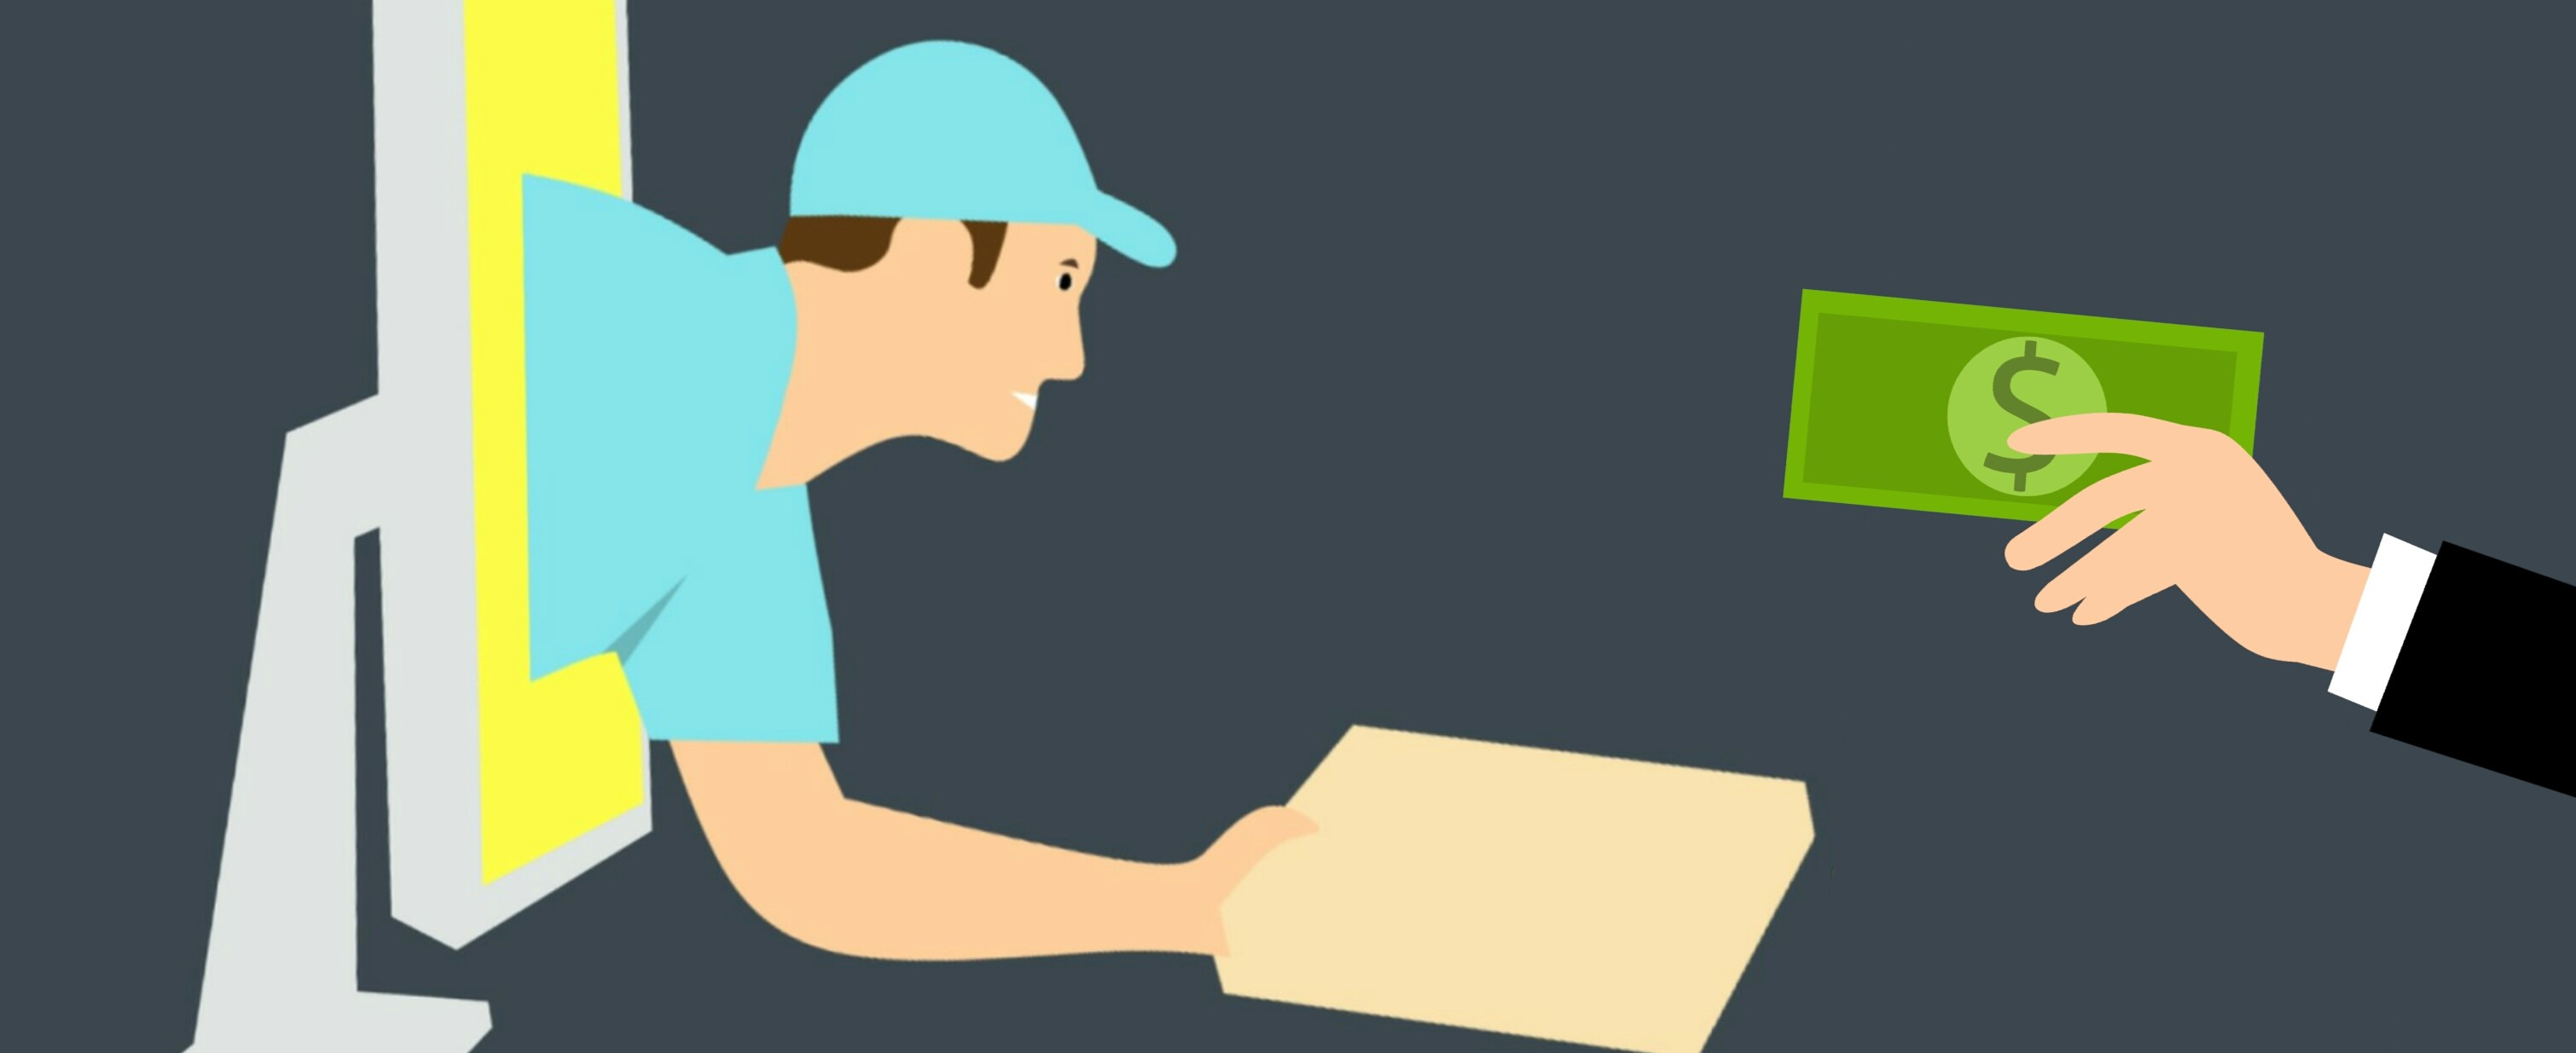

<font size="4">This database has been sourced from kaggle (link: https://www.kaggle.com/benroshan/online-food-delivery-preferencesbangalore-region). The goal is to see if we can predict customer churn. We will perform some visualizations before we go on to pre-process the data, after which we will implement classification models</font>

***

# Setting Up

<font size="3">Data Processing and Visualization Modules</font>

1. Numpy
2. Pandas
3. Seaborn
4. Matplotlib
5. Folium

<font size="3">Machine Learning Modules</font>

1. Train test split
2. Logistic Regression
3. Random Forest Classifier
4. K-Neighbors Classifier
5. SelectKBest
6. chi2
7. Confusion Matrix
8. Classification Report
9. Precision Score
10. Recall Score
11. Accuracy Score

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.display import HTML
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score

<font size="3">Importing data</font>

In [ ]:
data = pd.read_csv('../input/online-food-delivery-preferencesbangalore-region/onlinedeliverydata.csv')

<font size="3">Structure of our data</font>

In [ ]:
data.head()

In [ ]:
data.describe()

In [ ]:
data.info()

<font size="3">Even before moving on to the data visualization step, we can see that some form of dimensionality reduction will be required to avoid overfitting when we fit the model on this data. In the next steps we will see how we can do it.</font>

***

# Data Visualizations

### Continuous Variables

In [ ]:
%matplotlib inline

_ = [0, 6]
_ = list(enumerate([list(data.columns)[i] for i in _], start=1))

fig = plt.figure(figsize=[16,24])
for index, col_name in _:
    ax = fig.add_subplot(3, 1, index)    
    sns.countplot(x=col_name, data=data, hue='Output', palette='viridis')

<font size="3">There are no extreme values in both the continuous variables (age and family size), hence we do not need to treat the data for outliers. We can also see that reordering is more prevalent in age groups less than 25, and family size of less than 4</font>

### Categorical Variables

In [ ]:
# Creating a class for grouping categorical variables into frequency tables
class CategoricalGrouping():
    
    def __init__(self, data, col1, col2):
        self.data = data  # Pandas dataframe
        self.col1 = col1  # Column with categories for analysis
        self.col2 = col2  # Output variable
        
    @property
    def table(self):
        return self.data.groupby([self.col1, self.col2]).size().reset_index().pivot(
            columns=self.col1, index=self.col2, values=0).fillna(0)


# Defining a function to plot a nested pie chart
def nested_piechart(data, axis, wedge_width, pie_colors, chart_title):
    """This function takes the following arguments:
        
        data: a pandas dataframe of dimension greater than 2x1 (row x column)
        axis: matplotlib.axes.Axes object for plotting
        wedge_width: float, should be <=1
        pie_colors: list, color codes in hex, should be >= maximum # of categories
        chart_title: str, chart title to display
        
    """

    # Outer wedges
    wedges_outer, texts_outer = axis.pie(data.iloc[1], radius=1, wedgeprops=dict(width=wedge_width, edgecolor='w'), 
           startangle=90, colors=pie_colors)

    # Inner wedges
    axis.pie(data.iloc[0], radius=(1-wedge_width), wedgeprops=dict(width=wedge_width, edgecolor='w', alpha=0.7), 
           startangle=90, colors=pie_colors)

    axis.set(aspect="equal", title=chart_title)

    axis.legend(wedges_outer, list(data.columns),
              title=chart_title,
              loc="lower center",
              bbox_to_anchor=(0.85, -0.1, 0.5, 1))

    # Defining properties for annotations
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    y = np.sin(np.deg2rad(120))  # Converting degrees to radians
    x = np.cos(np.deg2rad(120))  # Converting degrees to radians

    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]  # Depending on the radians of x, will give -1 or 1
    connectionstyle = "angle,angleA=0,angleB={}".format(120)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})  # adding connection style args to kw dict
    axis.annotate(data.index[1], xy=(x, y), xytext=(1*np.sign(x), 1.2*y), 
                horizontalalignment=horizontalalignment, **kw)

    y = np.sin(np.deg2rad(140)) - 0.60  # Converting degrees to radians
    x = np.cos(np.deg2rad(140)) + 0.37  # Converting degrees to radians

    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]  # Depending on the radians of x, will give -1 or 1
    connectionstyle = "angle,angleA=0,angleB={}".format(140)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})  # adding connection style args to kw dict
    axis.annotate(data.index[0], xy=(x, y), xytext=(0.01*np.sign(x), -2*y), 
                horizontalalignment=horizontalalignment, **kw)


<font size="3">Below is an array of pie charts created for each categorical variable, with the hue set to the Output variable</font>

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=[16,40])

size = 0.3
c2 = 'Output'
c_palette = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

cat_var = ['Gender', 'Marital Status', 'Occupation', 'Monthly Income', 'Educational Qualifications', 'Medium (P1)', 
           'Medium (P2)', 'Meal(P1)', 'Meal(P2)', 'Perference(P1)', 'Perference(P2)']

ax_list = []

for ind, var in enumerate(cat_var):
    ax_list.append(fig.add_subplot(6, 2, (ind+1)))
    nested_piechart(CategoricalGrouping(data, var, c2).table, ax_list[ind], size, c_palette, var)
    


<font size="3">The variables Medium (P1), Medium (P2), Meal (P1) and Meal (P2) contribute little to no information which may help in predicting customer churn. In Medium (P1) for example, a customer who did not order again was using a food delivery app, which is redundant. Other variables also do not offer any more information, as the distribution of the classes seems the same.

We will now proceed to drop these variables</font>

In [ ]:
data.drop(['Medium (P1)', 'Medium (P2)', 'Meal(P1)', 'Meal(P2)'], axis=1, inplace=True)

### 3. Geospatial analysis

In [ ]:
%matplotlib inline

x = data.groupby(['latitude', 'longitude', 'Pin code']).size().reset_index()
x.columns = ['latitude', 'longitude', 'pincode', 'frequency']
x.sort_values(by=['frequency'], ascending=False, inplace=True)

latitude = 12.972442
longitude = 77.580643
delivery_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lon, freq, pin in zip(x['latitude'], x['longitude'], x['frequency'], x['pincode']):
    folium.CircleMarker([lat, lon], radius=freq, 
                        popup = ('Pincode: ' + str(pin) + '<br>' 
                                 '# of customers: ' + str(freq)
                                ), 
                        tooltip='Click to expand',
                        color='b', 
                        fill_color='red', 
                        fill=True, 
                        fill_opacity=0.6).add_to(delivery_map)

In [ ]:
delivery_map

<font size="3">We have 388 rows of data, but only 77 unique coordinates, which indicates that either there are only 77 customers in this data set, or the lat-lon location is not exact and adheres to a certain area. Since this dataset is derived from a survey, we can assume the latter. This is also substantiated by the fact that there are 77 unique pincodes in the dataset. The above map visualization shows the density of customers across various pincodes of Bangalore. </font>

<font size="3">We would drop the lat, lon and pincode variables from the data set. This is due to the fact that the data is comprised of responses from various individuals, and these set of variables provide no information other than where these individuals are situated in Bangalore.</font>

In [ ]:
data.drop(['latitude', 'longitude', 'Pin code'], axis=1, inplace=True)

### 4. Correlation Matrix

<font size="3">Before plotting the correlation matrix, we need to account for variables which are in the form of likert scales, and express them in the form of ordinal rank order scale. Then we will use Spearman's rank correlation to compute the correlation matrix for these variables in order to get a better understanding of our features</font>

In [ ]:
# Finding out all unique sets of categorical variables within the features
data_list = []
for r in data.iloc[:, np.r_[1, 4, 5, 9:47]].columns:
    df_row = list(data[r].unique())
    df_row = pd.Series(dict(enumerate(sorted(df_row))))
    data_list.append(df_row)

df_1 = pd.DataFrame(data=data_list, index=data.iloc[:,np.r_[1, 4, 5, 9:47]].columns)

df_1['combined'] = df_1.apply(lambda x: ', '.join(x.dropna().values.tolist()), axis=1)
df_1.drop([0, 1, 2, 3, 4], inplace=True, axis=1)
df_1 = df_1.reset_index()

df_1['index'] = df_1.groupby(['combined'])['index'].transform(lambda x : ','.join(x))
df_1 = df_1.drop_duplicates()
df_1.columns = ['features', 'data_categories']
df_1.drop([23, 24], axis=0, inplace=True)
df_1 = df_1.reset_index()
df_1.drop('index', axis=1, inplace=True)

x1 = list(enumerate([[0, 1], [2, 3, 1, 4, 0], 
                     [2, 4, 3, 1, 0], [4, 2, 3, 5, 1], 
                     [1, 2, 3, 4, 5], [4, 2, 3, 5, 1], 
                     [4, 3, 2, 1, 5], [1, 0]]
                   ))

for i, l in x1:
    df_1.at[i, 'data_categories'] = dict(zip(df_1.iloc[i, 1].split(', '), l))


In [ ]:
for i in df_1.index:
    for j in df_1.iloc[i, 0].split(','):
        data[j] = data[j].apply(lambda x: df_1.iloc[i, 1][x])

In [ ]:
%matplotlib inline


fig = plt.figure(figsize=[32, 18])
sns.heatmap(data.corr(method='spearman'), annot=False, mask=np.triu(data.corr(method='spearman')), cmap='Spectral', 
            linewidths=0.1, linecolor='white')

<font size="3">We notice that not only are features from 'Ease and convenient' to 'Good Tracking system' correlated with our output variable, but also with each other. In fact, if we observe the diagonals, we can see which features are correlated with each other, which gives us an insight as to how we can compress the multiple dimensions in our variables. One of the popular dimensionality reduction methods, principal component analysis will not help in this case because the variables are of ordinal categorical nature rather than continuous. We will use other feature selection methods later in the data pre-processing stage</font>

***

# Data Pre-processing

Some of the pre-processing has been done in the visualization step itself, where we converted likert features to an ordinal scale. There are a few features remaining which are still categorical. We will convert these to dummy variables now

In [ ]:
_ = pd.get_dummies(data.iloc[:, [2, 3, 7, 8, 29, 30, 37]], drop_first=True)
data.drop([data.columns[i] for i in [2, 3, 7, 8, 29, 30, 37, 47]], axis=1, inplace=True)
data = data.join(_)
data

In [ ]:
X = data.drop('Output', axis=1) # input categorical features
y = data['Output'] # target variable

In [ ]:
sf = SelectKBest(chi2, k='all')
sf_fit = sf.fit(X, y)

chi2_scores = pd.DataFrame([sf_fit.scores_, X.columns], index=['feature_score', 'feature_name']).transpose()
chi2_scores = chi2_scores.sort_values(by=['feature_score'], ascending=True).reset_index().drop('index', axis=1)

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=[10, 20])
plt.barh(chi2_scores['feature_name'], chi2_scores['feature_score'], align='center', alpha=0.5)
plt.xlabel('Score')

<font size="3">As a starting point, we will select the top 20 features with the highest feature scores and see if we need to drop any variables later due to overfitting</font>

In [ ]:
X = X[list(chi2_scores.iloc[-20:,1])]
X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

***

# Modeling

### 1. Logistic Regression

In [ ]:
log_model = LogisticRegression(max_iter=10000)
log_model.fit(X_train, y_train)

log_pred = log_model.predict(X_test)

print(classification_report(y_test, log_pred))
print(confusion_matrix(y_test, log_pred))

### 2. Random Forest

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

print(classification_report(y_test, rfc_pred))
print(confusion_matrix(y_test, rfc_pred))

### 3. K Nearest Neighbors

Checking metrics for different values of k

In [ ]:
error_rate = []

for i in range(1,11):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append([accuracy_score(y_test, pred_i), precision_score(y_test, pred_i), 
                       recall_score(y_test, pred_i)])

error_rate = pd.DataFrame(error_rate, columns=['accuracy_score', 'precision_score', 'recall_score'])
error_rate.plot()

We get best performance at k = 7, and hence we'll train the model as such

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)

knn_pred = knn_model.predict(X_test)

print(classification_report(y_test, knn_pred))
print(confusion_matrix(y_test, knn_pred))

***

# Conclusion

<font size="3">Out of all models created, Random Forest and K Nearest Neighbors give the best performance. K Nearest Neighbors has the added advantage of being relatively simpler to interpret, without any sacrifice in accuracy.

Another consideration is about the data itself. We see that most of the variables that have a material impact on customer churn relate to broad aspects of ease and convenience. In fact, the subset of features selected in the model could inform business decisions, regarding which aspects of the service could be focused on for minimizing churn, and what user segments should the marketing dollars be spent on.</font>

Next Steps:

1. To extract even more out of the data set, we could further explore other dimensionality reduction methods, such as multiple correspondence analysis which solves the issue of principal component analysis not being suited to categorical data

2. We ignored the text data, i.e. reviews in this analysis, and analysing with NLP methods could also add to the analysis

3. Could we tune the model further by adding/subtracting variables?